<a href="https://colab.research.google.com/github/AlyGamalAbusenna/Face-Detection-Recognition/blob/main/Face_Detection_%26_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score

# Set seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load Dataset from Kaggle and set paths
data_path = '/kaggle/input/'  # Adjust path based on the Kaggle Notebook environment
faces_path = os.path.join(data_path, 'pins-face-recognition')

# **Upload the needed files**

In [ ]:
import requests

!wget -O /kaggle/working/opencv_face_detector.pbtxt https://github.com/opencv/opencv_extra/raw/master/testdata/dnn/opencv_face_detector.pbtxt
!wget -O /kaggle/working/opencv_face_detector_uint8.pb https://github.com/opencv/opencv_3rdparty/raw/8033c2bc31b3256f0d461c919ecc01c2428ca03b/opencv_face_detector_uint8.pb

face_proto = "/kaggle/working/opencv_face_detector.pbtxt"
face_model = "/kaggle/working/opencv_face_detector_uint8.pb"

# Load Pre-trained OpenCV Face Detection Model from the local files
net = cv2.dnn.readNetFromTensorflow(face_model, face_proto)



/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-11-07 13:45:43--  https://github.com/opencv/opencv_extra/raw/master/testdata/dnn/opencv_face_detector.pbtxt
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/opencv_face_detector.pbtxt [following]
--2024-11-07 13:45:43--  https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/opencv_face_detector.pbtxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34975 (34K) [text/plain]
Saving to: '/kaggle/working/opencv_face_detector.pbtxt'

/kaggle/working/ope 100%[===================>]  34.16K  --.-KB/s    in 0.01s   

2024-11-07 13:45:43 (3.

# **Data Preprocessing**

## ***Crop the faces in the images***

In [ ]:
# Function to detect faces using OpenCV DNN
def detect_face(image):
    h, w = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), [104, 117, 123], False, False)
    net.setInput(blob)
    detections = net.forward()
    faces = []

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.7:  # Detection confidence threshold
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            face = image[startY:endY, startX:endX]
            faces.append(face)
    return faces


In [ ]:
import os
import cv2

# Define paths
data_path = '/kaggle/input/pins-face-recognition/105_classes_pins_dataset'
cropped_faces_dir = "/kaggle/working/cropped_faces"
os.makedirs(cropped_faces_dir, exist_ok=True)

# Loop through each person folder in the dataset
for person_folder in os.listdir(data_path):
    person_folder_path = os.path.join(data_path, person_folder)

    # Ensure that the current folder path is a directory (skip non-directory files)
    if not os.path.isdir(person_folder_path):
        continue

    # Create a directory for the current person in the output cropped faces directory
    save_path = os.path.join(cropped_faces_dir, person_folder)
    os.makedirs(save_path, exist_ok=True)

    # Loop through all images in the person's folder
    for image_name in os.listdir(person_folder_path):
        image_path = os.path.join(person_folder_path, image_name)
        image = cv2.imread(image_path)

        # Check if the image was loaded successfully
        if image is None:
            print(f"Warning: Could not load image {image_path}. Skipping.")
            continue

        # Detect faces in the image
        faces = detect_face(image)

        # Save each detected face as a separate image
        for i, face in enumerate(faces):
            # Ensure the face has valid dimensions before saving
            if face.shape[0] > 0 and face.shape[1] > 0:
                cropped_face_path = os.path.join(save_path, f"{i}_{image_name}")
                cv2.imwrite(cropped_face_path, face)


## ***Split the preprocessed data***

In [ ]:
# Splitting Dataset into Training and Validation
train_data_path = cropped_faces_dir
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 14124 images belonging to 105 classes.
Found 3475 images belonging to 105 classes.


## ***Load Pre-trained VGG16 Model and add some extra layeres***

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Adding Custom Layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## ***Model Training***

In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, validation_data=validation_generator, epochs=20)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730987760.145034     123 service.cc:145] XLA service 0x7c0350010480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730987760.145109     123 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730987760.145115     123 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1730987797.100773     123 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


442/442 ━━━━━━━━━━━━━━━━━━━━ 252s 477ms/step - accuracy: 0.0126 - loss: 4.6624 - val_accuracy: 0.0124 - val_loss: 4.6375
Epoch 2/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 199s 417ms/step - accuracy: 0.0134 - loss: 4.6364 - val_accuracy: 0.0112 - val_loss: 4.6412
Epoch 3/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 188s 425ms/step - accuracy: 0.0141 - loss: 4.5693 - val_accuracy: 0.0201 - val_loss: 4.2677
Epoch 4/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 188s 425ms/step - accuracy: 0.0293 - loss: 4.1445 - val_accuracy: 0.0633 - val_loss: 3.7718
Epoch 5/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 188s 425ms/step - accuracy: 0.0690 - loss: 3.7361 - val_accuracy: 0.1045 - val_loss: 3.5979
Epoch 6/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 188s 424ms/step - accuracy: 0.1080 - loss: 3.4612 - val_accuracy: 0.1796 - val_loss: 3.1702
Epoch 7/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 192s 435ms/step - accuracy: 0.1972 - loss: 3.0754 - val_accuracy: 0.2878 - val_loss: 2.6917
Epoch 8/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 194s 437ms/step - accuracy: 0.2911 - loss: 2.59

## ***Model Evaluation***

109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.7369 - loss: 1.0575
Validation Accuracy: 73.50%


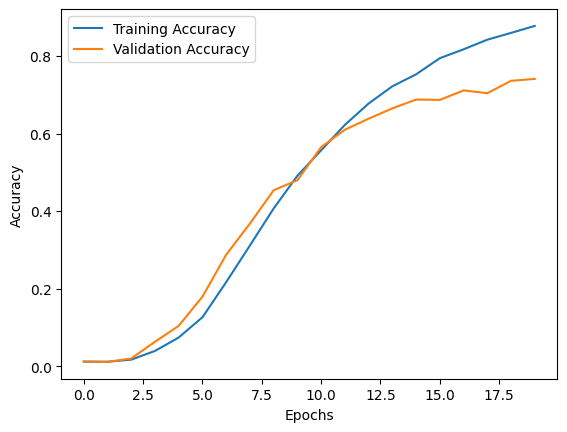

In [ ]:
# Evaluate the model
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

# Plotting training and validation accuracy for visualization
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

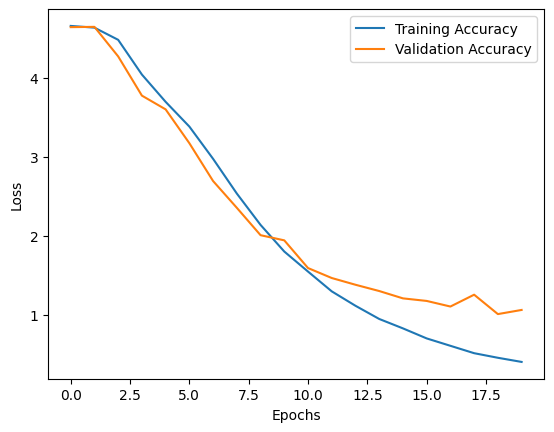

In [ ]:
# Plotting training and validation loss for visualization
plt.plot(history.history['loss'], label='Training Accuracy')
plt.plot(history.history['val_loss'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.save('face_recognition_model.h5')

## ***Detect the Not Identify Images***

In [ ]:
import random

# Cosine similarity function
def cosine_similarity(face_embedding1, face_embedding2):
    dot_product = np.dot(face_embedding1, face_embedding2)
    norm_a = np.linalg.norm(face_embedding1)
    norm_b = np.linalg.norm(face_embedding2)
    return dot_product / (norm_a * norm_b)

# Extract face embeddings using the trained model
def get_face_embedding(model, image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = image / 255.0  # Normalize the image
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    embedding_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)  # Use the second last layer for embeddings
    embedding = embedding_model.predict(image)
    return embedding.flatten()

# Predict the class of an unknown image
def predict_class(model, image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = image / 255.0  # Normalize the image
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    predictions = model.predict(image)
    predicted_class_index = np.argmax(predictions)
    predicted_class = list(train_generator.class_indices.keys())[predicted_class_index]
    return predicted_class

# Function to classify a new face
def classify_face(model, unknown_image_path, known_embeddings_dir, threshold=0.80, num_samples=30):
    # Step 1: Predict the class of the unknown image
    predicted_class = predict_class(model, unknown_image_path)
    print(f"Predicted Class: {predicted_class}")

    # Step 2: Extract embedding of the unknown image
    unknown_embedding = get_face_embedding(model, unknown_image_path)

    # Step 3: Extract embeddings of multiple images from the predicted class and calculate cosine similarities
    predicted_class_path = os.path.join(known_embeddings_dir, predicted_class)
    class_images = os.listdir(predicted_class_path)

    # Select a random subset of images from the predicted class
    if len(class_images) > num_samples:
        class_images = random.sample(class_images, num_samples)

    # Calculate cosine similarity for each selected image
    similarities = []
    for img_file in class_images:
        img_path = os.path.join(predicted_class_path, img_file)
        known_embedding = get_face_embedding(model, img_path)
        similarity = cosine_similarity(unknown_embedding, known_embedding)
        similarities.append(similarity)

    # Compute the average cosine similarity
    average_similarity = np.mean(similarities)

    # Step 4: Decide if the face is from the predicted class
    if average_similarity > threshold:
        return predicted_class
    else:
        return "not identified"


In [ ]:
# Example usages:

# Classify the known face of Zac Efron :
result = classify_face(model, "/kaggle/input/known/keras/default/1/face_Zac Efron2_1687.jpg", train_data_path)
print(result)
print("-------------------------------")

# Classify the known face Zendaya :
result = classify_face(model, "/kaggle/input/known/keras/default/1/face_Zendaya22_1857.jpg", train_data_path)
print(result)
print("-------------------------------")



# Classify the unknown face 1:
result = classify_face(model, "/kaggle/input/pic/keras/default/1/adel_emam2.jpeg", train_data_path)
print("Adel Emam-->",result)
print("-------------------------------")


# Classify the unknown face 2:
result = classify_face(model, "/kaggle/input/pic/keras/default/1/koshary.jpeg", train_data_path)
print("Fatma Koshary-->",result)
print("-------------------------------")




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Class: pins_Zac Efron
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms

# **Bonus**

## ***Applying Live Face Detection and Recognetion***
### ***Note to run this you must run it localy to acess the webcam***

In [ ]:
python live_face_recognition.py

def live_face_recognition(model, known_embeddings_dir, threshold=0.75, num_samples=20):
    # Load OpenCV's pre-trained face detector
    face_net = cv2.dnn.readNetFromTensorflow("opencv_face_detector_uint8.pb", "opencv_face_detector.pbtxt")

    # Start webcam feed
    cap = cv2.VideoCapture(0)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Step 1: Detect faces in the frame
        h, w = frame.shape[:2]
        blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), (104.0, 177.0, 123.0))
        face_net.setInput(blob)
        detections = face_net.forward()

        # Step 2: Loop through the detected faces
        for i in range(detections.shape[2]):
            confidence = detections[0, 0, i, 2]
            if confidence > 0.5:
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")

                # Step 3: Extract the face from the frame
                face = frame[startY:endY, startX:endX]

                if face.shape[0] > 0 and face.shape[1] > 0:
                    # Step 4: Predict the class of the face
                    predicted_class = predict_class(model, face)

                    # Step 5: Extract embedding of the face and classify using cosine similarity
                    unknown_embedding = get_face_embedding(model, face)
                    result = classify_face(unknown_embedding, predicted_class, known_embeddings_dir, threshold, num_samples)

                    # Step 6: Draw the bounding box and label on the frame
                    label = f"{result}: {confidence*100:.2f}%"
                    cv2.rectangle(frame, (startX, startY), (endX, endY), (0, 255, 0), 2)
                    cv2.putText(frame, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

        # Step 7: Display the video feed with the recognized faces
        cv2.imshow("Live Face Recognition", frame)

        # Break the loop with the 'q' key
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the video capture and close windows
    cap.release()
    cv2.destroyAllWindows()

# Example usage
live_face_recognition(model, train_data_path)